<a href="https://colab.research.google.com/github/dakken205/dl-lec/blob/main/04/04_nn_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize_matplotlib

In [2]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

import japanize_matplotlib

# ニューラルネットワークの学習
ここでいう学習とは，ニューラルネットワークの重みを適切に調整することを指します．    
以前，ANDゲートやNANDゲートを実装する際に，パーセプトロンの重み(w1, w2)をどのような値にするか決定しましたが，その操作に該当します． 
基本的に，ニューラルネットワークでは，何かしらの目的を設定して，それに応じた損失関数を定義し，この損失関数が最小となるようにパラメータを調整していくことになります．
例）    
目的：論理ゲートだと入力に対して，適切な０または１を出力したい  
損失関数：予測した０と１が本来出力したい０と１の出力とどれくらい間違っているのか

## データから学習
ニューラルネットワークを含む，機械学習を導入するメリットとしては，**データから学習できる**という点です．    
全勝で私たちが実装した論理ゲートは，パラメータが2つ程度だったので調整出来ましたが，GPT-4(chatGPTの有料版モデルで利用できるやつ)では，なんとパラメータ数が170兆個になります．    
流石にこれを手動で合わせることは出来ませんよね．．．  

＜脱線ですが．＞    
実際，AIの種類の1つであるエキスパートシステムでは，目的とするタスクに詳しい専門家がプログラムを組んで(ニューラルネットワークに限らない）出来上がったものを実行するエキスパートシステムというものが存在しますが，先ほどの議論と同様に，実装コストが非常に大きくなります．

### データ駆動
機械学習では，人が「ああではないか，こうではないか」と考えることはしません．極力人の介入を減らして，データから学習するようにします．    
<p>以下，人だけで手書き文字認識を考える際と，人・機械学習を用いた際，ニューラルネットワークを利用した際の差を示します．ここで，特徴量という表現が出てきていますが，これは，入力データから本質的なデータを取得するための変換器になっています（少なくとも<u>ここでの文脈では</u>です．)</p>
<img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/567823/a5ad1e04-bfd0-3700-1d6f-f763ca62ea1e.png" />

機械学習とディープラーニング（深層学習）の違いとしては，機械側に入力するためのデータを，人間が設計する必要があるかの違いです．  
機械学習では，入力データを人が設計した変換器でデータの本質を事前に取得する必要が（あるモデルも）ありますが，深層学習では画像データをそのまま入力し，その画像自体を使って学習します．

### 訓練データとテストデータ

深層学習を含む機械学習全般では，パラメータの推定（つまり学習）をする際に，パラメータ推定時に利用するデータと，モデルの性能を図るためのデータを分けて運用します． 

<!-- ＜例＞  
あなたは，学校の先生で，担当している授業をどれくらい生徒が理解しているのか知りたいとします．その際に，理解度を調査するための，成績に響くような10問の小テストを実施しようと考えました．それに向けて，適当に選んだ練習問題30問を用意して，その30問から小テストの10問を出すと宣言しました．この状況下において，小テストの評価は，練習問題30問の範囲を超えた成績に近いと言えるかどうか．<br><br> -->

私たちがモデルに求める性能は，与えたデータだけに対した予測の精度ではありません．例えば，株価の予測などでは，これからの株価の予測に興味があるのです．    
そこで，モデルを学習する際に利用していないデータを用いて，評価を行うことで，どれくらいそのタスクにおいて汎用的なのか知ろう．というわけです．    
また，学習したデータだけに高精度に対応した状態の事を**過学習**（overfitting）と言います

## 損失関数
損失関数とは，今目的としているタスクに対して，どれくらいミスを犯しているのか，といった指標です．深層学習では，この1つの指標を基に，パラメータを学習していくことになります． 
この損失関数には，任意の関数を適用できますが，一般的には，**2乗和誤差**や**交差エントロピー**が使われます．

### 2乗和誤差
$$
\displaystyle E = \frac{1}{2} \sum_{k} (\hat{y} - y)
$$
この式は，名前の通り，予測した値と実際の予測値の差（誤差）の2乗和を求めている．     
以下に，簡単にプログラムで実装してみます

In [3]:
y_pred = [1, 2, 3, 4, 5, 6]
y_true = [1, 0, 3, 0, 5, 5]

err = 0

for i in range(len(y_pred)):
    y_pred_i = y_pred[i]
    y_true_i = y_true[i]
    err += (y_pred_i - y_true_i) ** 2
err /= 2
print(err)

10.5


合っているのか計算してみると    
$\frac{1}{2}(2^2 + 4^2 + 1^2) = \frac{1}{2}・21 = 10.5$

計算速度を早くしたいので，numpyのメソッドを利用して実する関数を定義しておきます

In [4]:
def sum_squared_error(y_pred: np.ndarray, y_true: np.ndarray):
    if not isinstance(y_pred, np.ndarray): y_pred = np.array(y_pred)
    if not isinstance(y_true, np.ndarray): y_true = np.array(y_true)
    err = y_pred - y_true
    err **= 2
    err_score = np.sum(err)
    err_score /= 2
    return err_score

In [5]:
sum_squared_error(y_pred, y_true)

10.5

### 交差エントロピー
交差エントロピーは，基本的にそれぞれのクラス（あるいはラベル）に帰属する確率を出力するようなケースで利用されます．
$$
\displaystyle E = -\sum_{k} t_k\log{y_k}
$$
この時，$t_k$はk個目のクラスに帰属するかどうかを表す0,1の変数です．帰属する際は1,しない際は0を取るような変数です．$y_k$は，機械が出力した，k個目のクラスに属する確率です．
この関数がなぜそうなるのか，関数を描画して考えてみましょう

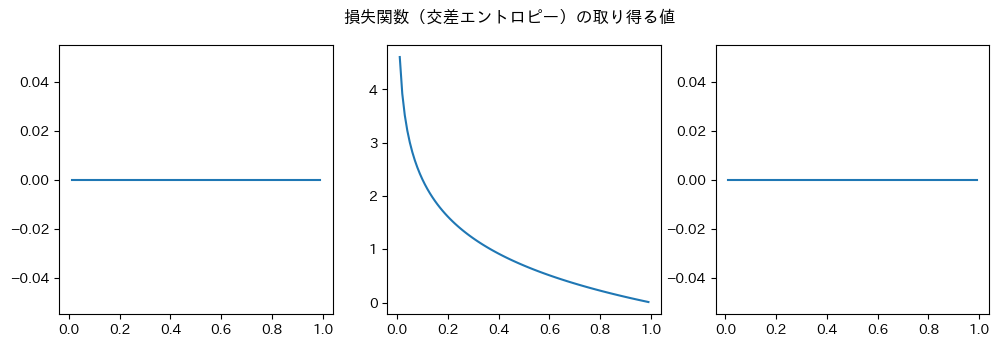

In [6]:
t_0 = 0
t_1 = 1
t_2 = 0
y = np.linspace(0.01, 0.99, 100)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
axs[0].plot(y, - t_0 * np.log(y))
axs[1].plot(y, - t_1 * np.log(y))
axs[2].plot(y, - t_2 * np.log(y))
plt.suptitle('損失関数（交差エントロピー）の取り得る値')
plt.show()

今回，正解クラスは2つ目のクラスです．   
2つ目のグラフを見てみると，正解ラベルの確率を低く予想しているときは高い値を，確率を高く予想しているときは低い値を取るようになっていることが分かります．     
また，グラフからもうひとつ分かることが，この関数は，正解ラベルだけが損失に影響しているという点です．    
つまり，この損失関数は，正解ラベルの予測確率を高く出力しているのか？という点に焦点があるわけです．    
では，実装していきましょう．

In [7]:
def cross_entropy_error(y_pred: np.ndarray, y_true: np.ndarray):
    """
    y_pred: [[0.9, 0.1, 0.0, 0.0, ...],...]
    y_true: [[1.0, 0.0, 0.0, 0.0, ...],...]
    """
    if not isinstance(y_pred, np.ndarray): y_pred = np.array(y_pred)
    if not isinstance(y_true, np.ndarray): y_true = np.array(y_true)
    delta = 1e-7
    return -np.sum(y_true * np.log(y_pred + delta))


＊余談ですが，確率に帰属させるための活性化関数として，シグモイド関数とソフトマックス関数を既に紹介しましたが，この交差エントロピーを用いて正確に損失を取得しようとすると，この二つのうちであれば，ソフトマックスを適用すべきです．  
というのも，シグモイド関数はそれぞれのクラスに帰属する確率を表しますが，その確率は0~1という制約しか持ちません．ソフトマックスであれば，各クラスへ帰属する確率が合計で1になるように設定されているので，正解ラベルへ帰属する確率を上げることは，同時に他のクラスに帰属する確率を下げる事に該当し，極端な例でいえば，すべてのクラスに確率１を出力するといった（これでも交差エントロピーは0になる）事を回避できます．

### ミニバッチ学習

#### 損失関数の複数データへの対応

機械学習では，上で定義した損失関数を用いて，訓練データに対するその損失が小さくなる方向にパラメータを調整していく．  
つまり，損失は，一つ一つのデータからではなく，訓練データ全体からの誤差が知りたいのである．  
その点，先ほどの損失関数では，データが1つの時にしか対応していないので，これをある程度の大きさを持った訓練データに対応するように定義する
$$\displaystyle \frac{1}{N} \sum_n \sum_k t_{nk}\log{y_{nk}}$$
このとき，nはn個目のデータであり，kはk番目のクラスである    
つまり，N個のデータの交差エントロピーの平均を取っていることになる．平均を取る理由は，訓練データのサイズに寄らず，統一した指標で損失関数の値を見ることが出来る為である．   

#### ミニバッチ学習とは

以前利用した手書き文字データセット（MNISTデータセット)では，データ数が60,000ありました．これでも十分大きな値に感じる人もいるかもしれませんが，ビッグデータとなると更に膨大なサイズになってきます．そのようなデータセットに対して，全データの損失を求め，パラメータを逐次更新していく作業は，現実的ではありません．      
そこで，訓練データの1部分，たとえば64個（$2^6$)等をランダムに抽出して，データセットを近似し，そこからパラメータを学習させる手法を，ミニバッチ学習と言います．<br><br>
以下，実装方法になります（一番下だけ重要）

In [8]:
# ミニバッチにするデータインデックスの取得方法
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (_, _) = mnist.load_data()
y_train = to_categorical(y_train)

print('訓練データの形状')
print(x_train.shape)
print(y_train.shape)

n_batch = 2 ** 6
np.random.choice(x_train.shape[0], n_batch)

訓練データの形状
(60000, 28, 28)
(60000, 10)


array([54203, 11423, 20084, 17920,   625, 22108, 39612,  4907, 21642,
        3910, 58225, 46977, 16957, 53207, 27865,  9025,   966, 31223,
       20833, 27587,  1346, 32653, 32165, 42592, 31835, 47164, 10735,
       47622, 23943,  1188, 17149, 56980, 53053, 59732,  5896, 24669,
       22808,  3695, 23156, 49918, 43643, 24043, 29969, 58530, 41066,
        8984, 43907,  6511, 38075, 56095, 33521, 43398, 39881, 17894,
       30664, 51210,  6383, 35197, 39119, 33995,  2051, 29304,  6104,
       46623])

### [バッチ対応版]交差エントロピーの実装

In [9]:
# 教師データがone-hot表現
def cross_entropy_error(y_pred: np.ndarray, y_true: np.ndarray):
    if not isinstance(y_pred, np.ndarray): y_pred = np.array(y_pred)
    if not isinstance(y_true, np.ndarray): y_true = np.array(y_true)
    if y_pred.dim == 1:
        y_pred.reshape(1, y_pred.size)
        y_true.reshape(1, y_true.size)
    delta = 1.e-7
    n_batch = y_pred.shape[0]
    return -np.sum(y_true * np.log(y_pred + delta)) / n_batch


### 損失関数を設定する意義

ニューラルネットワーク叱り，機械学習全般しかりであるが，それぞれのモデルを学習する意義は，目的のタスクを精度良くこなすためである．例えば，手書き文字認識であれば，その認識精度が高いようなモデルを得たい訳である．  
それなのになぜ，認識精度ではなく，損失関数を指標にするのか．それは，ニューラルネットワークが，微分をベースにパラメータを更新する点に着目する．  
パラメータの学習は，損失関数を着目するパラメータの微分がプラスであれば，マイナスの方向へ，微分がマイナスであればプラスの方向へといった流れで行われ，この微分が0になった段階で，学習が終了したことになると考える．
詳しい手法は，後から出てくるが，これに関して，微分をベースに考えると，認識精度だと，ほとんどの場所で認識精度が０になってしまう（出力するラベルが切替るタイミングでしか勾配が生じない）ため，微分を利用した学習が上手く適用できない為です．

## 数値微分


### 微分
$\displaystyle \frac{df}{dx} = \lim_{h→x}\frac{f(x+h) - f(x)}{(x+h) - x} = \lim_{h→x}\frac{f(x+h) - f(x)}{h}$

In [10]:
# 悪い実装例
def numerical_diff(f, x):
    h = 1e-50
    return (f(x+h) - f(x)) / h


#### 問題点１：丸め誤差
値が小さすぎると，丸め誤差が生じることになる．丸め誤差とは，小数点以下の数値が小さすぎて省略されることによって生じるエラーです．

In [11]:
print(1e-50)
print(np.float32(1e-50))
print(np.float64(1e-50))

1e-50
0.0
1e-50


#### 問題点２：中央差分と前方差分
上記のケースだと，差分について考える際に，片側（前方）だけの差分(前方差分）考えていることになります．    
これだと，以下のグラフが示すように，正確な微分が出来ない．従って，両方からの差分（中央差分）を取るようにすることで，より精度の良い数値微分を行うことが可能である．

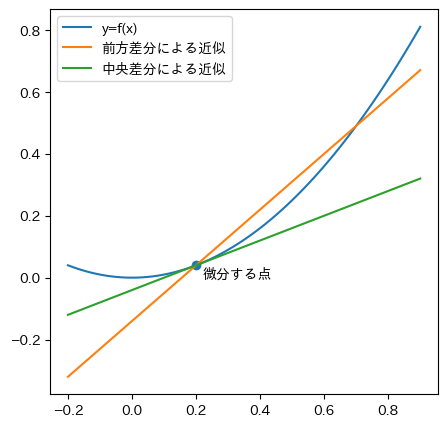

In [12]:
plt.figure(figsize=(5, 5))
f = lambda x: x**2
x = np.linspace(-.2, .9, 100)
x_1 = 0.2
y_1 = f(x_1)
h = 0.5
a_1 = (f(x_1+h)-f(x_1))/h
b_1 = y_1 - a_1*x_1
g_1 = lambda x: a_1*x + b_1

a_2 = (f(x_1+h)-f(x_1-h))/ (2*h)
b_2 = y_1 - a_2*x_1
g_2 = lambda x: a_2*x + b_2

plt.plot(x, f(x), label='y=f(x)')
plt.plot(x, g_1(x), label='前方差分による近似')
plt.plot(x, g_2(x), label='中央差分による近似')
plt.scatter(x_1, y_1)
plt.text(0.22, 0.0, '微分する点')
plt.legend()
plt.show()

#### 改善版

In [13]:
def numerical_diff(f, x):
    # 1e-4くらいが丁度いい結果が得られることが知られているらしい
    h = 1e-4
    return (f(x+h) - f(h-h)) / 2*h


### 数値微分の例
実際に求めてみる: $f(x)=0.01x^2+0.1x$

In [14]:
def function_1(x):
    return 0.01 * x ** 2 + 0.1 * x


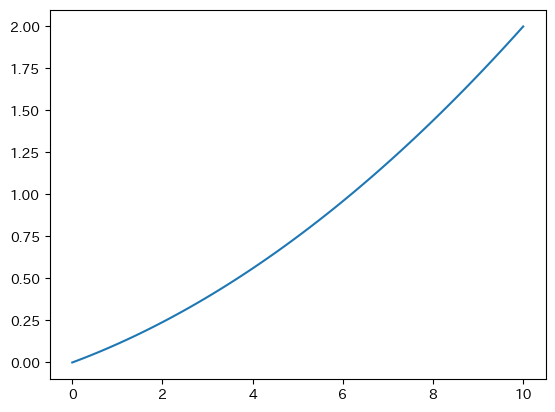

In [15]:
x = np.linspace(0, 10, 100)
plt.plot(x, function_1(x))
plt.show()

In [16]:
numerical_diff(function_1, 5)

3.7501000005e-05

In [17]:
numerical_diff(function_1, 10)

0.00010000150000499999

### 偏微分

以下の，変数が2つの関数について考えます．   
$$f(x_0, x_1)=x_0^2+x_1^2 : (1)$$

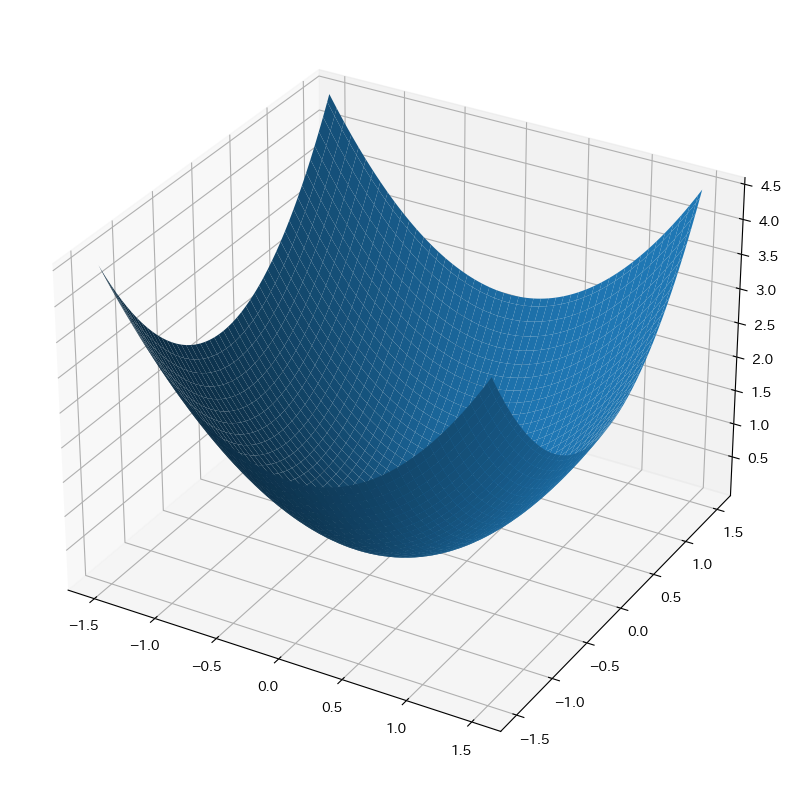

In [18]:
f = lambda x_0, x_1: x_0**2 + x_1**2

region = 1.5
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x_0 = np.linspace(-region, region, 100)
x_1 = np.linspace(-region, region, 100)
X_0, X_1 = np.meshgrid(x_0, x_1)

ax.plot_surface(X_0, X_1, f(X_0, X_1))
plt.show()

このとき，$(1)$に対して微分をする際には，どちらかの変数に対して着目するようにします．つまり，$x_0$に対する微分と,$x_1$に対する微分を別で考え，それぞれの微分について考える際には，もう片方の変数を定数的に考えることになります．    
つまり，上記の$f(X)$に対して，$x_0$に対して微分を行うと$\frac{\delta{f}}{\delta{x_0}} = 2x_0$になります

## 勾配

勾配を計算し，その勾配を可視化してみよう．  
先ほども書きましたが，勾配は，微分した値をマイナスすることで計算されます．

In [19]:
def numerical_gradient(f, x):
    """
    x: 1次元のベクトル. 1サンプルごとの処理を行う
    """
    h = 1e-4
    grads = np.zeros_like(x)

    # それぞれのxの方向に対して，勾配を見ていく
    for idx in range(x.size):
        tmp_val = x[idx]
        # 勾配を見たい特徴量について+h時点での座標を取得
        x[idx] = tmp_val + h
        fxh1 = f(*x)
        # 勾配を見たい特徴量について-h時点での座標を取得
        x[idx] = tmp_val - h
        fxh2 = f(*x)
        # 上の二つを用いて，中央差分を取得
        grads[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    return grads

In [20]:
numerical_gradient(f, np.array([3., 4.]))

array([6., 8.])

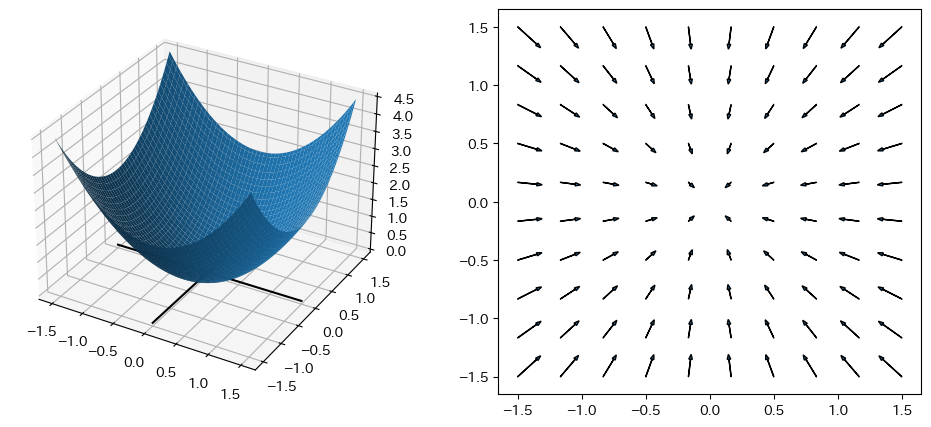

In [21]:
f = lambda x_0, x_1: x_0**2 + x_1**2

region = 1.5
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)
x_0 = np.linspace(-region, region, 100)
x_1 = np.linspace(-region, region, 100)
X_0, X_1 = np.meshgrid(x_0, x_1)
ax1.plot_surface(X_0, X_1, f(X_0, X_1))
ax1.plot(np.repeat(0, x_1.size), x_1, np.repeat(0, x_1.size), color='k')
ax1.plot(x_0, np.repeat(0, x_0.size), np.repeat(0, x_0.size), color='k')

# Create a figure and an axes
xs = np.linspace(-region, region, 10)
ys = np.linspace(-region, region, 10)
coordinates = np.array(tuple(it.product(xs, ys)))
grads = np.zeros_like(coordinates)

for idx in range(len(coordinates)):
    coordinate = coordinates[idx]
    grad = numerical_gradient(f, coordinate)
    grads[idx] = grad
for i in range(0, coordinates.shape[0]):
    ax2.arrow(coordinates[i, 0], coordinates[i, 1], -0.05*grads[i, 0], -0.05*grads[i, 1], head_width=0.028)

plt.show()

### 勾配法

勾配法では，先ほど求めた，勾配を利用して，パラメータを更新していきます．    
先ほどのケースでいえば，$x_0, x_1$の勾配が，どこからでも$(0, 0)$の方向に向かっていましたよね．  
勾配法では，この勾配を利用し，適当に取った最初の$x_0, x_1$の値を，損失関数が最小になる場所（今回だと$(0, 0)$）に向かわせます．  
以下が，勾配法を示す数式になります．
$$x_0 = x_0 - \eta \frac{\delta f}{\delta x_0}$$
$$x_1 = x_1 - \eta \frac{\delta f}{\delta x_1}$$

この時，$\eta$は学習率と言い，一度の学習によって勾配をどれくらい適用するのかを調整する値です．  
また，$\frac{\delta f}{\delta x_0}$, $\frac{\delta f}{\delta x_1}$はそれぞれ$f(x)$に対する$x_0$, $x_1$の微分になっています．

In [22]:
def gradient_descent(f, init_x, lr, step_num=100):
    x = np.array([init_x[0], init_x[1]])
    x_step = np.zeros((step_num, 2))
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
        x_step[i] = x
    return x, x_step


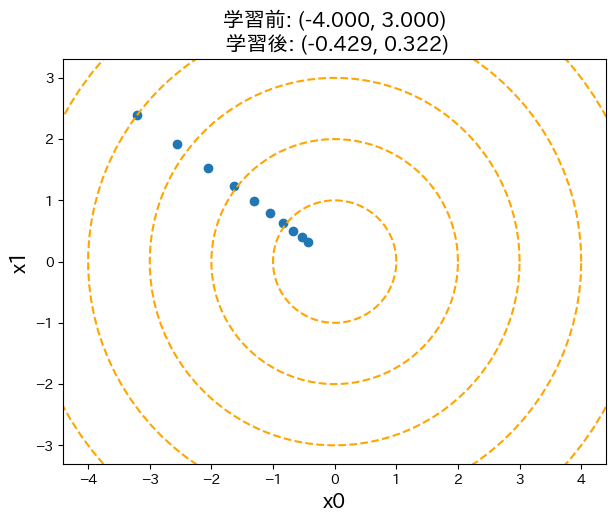

In [23]:
# 初期座標とステップ数．この二つの値を変えてみよう
# x_text = input('[x1, x2]の形式で入力してください：')
# x = eval(f"np.array([{x_text}], dtype='float')")
x = np.array([-4, 3], dtype='float')
step_num = 10

x_abs = np.abs(x)

# 勾配のプロット
x_res, x_step = gradient_descent(f, x, 0.1, step_num)
plt.figure(figsize=(7*(x_abs[0]/max(x_abs)), 7*(x_abs[1]/max(x_abs))))
plt.scatter(*x_step.T)

# 円のプロット
n_samples = 100
n_dim = 2
coordinates = np.zeros((n_samples, n_dim))
theta_array = np.linspace(0, 2*np.pi, n_samples)
idx_array = np.arange(n_samples)
x_0 = np.cos(theta_array)
x_1 = np.sin(theta_array)
for base in range(1, int(max(x_abs+2))):
    plt.plot(base*x_0, base*x_1, linestyle='--', color='orange')
plt.xlabel('x0', fontsize=15)
plt.ylabel('x1', fontsize=15)
plt.xlim(-x_abs[0]*1.1, x_abs[0]*1.1)
plt.ylim(-x_abs[1]*1.1, x_abs[1]*1.1)
plt.title(f'学習前: ({x[0]:.3f}, {x[1]:.3f})\n 学習後: ({x_res[0]:.3f}, {x_res[1]:.3f})', fontsize=15)
plt.show()

### ニューラルネットワークに対する勾配

ニューラルネットワークにおいて調整する値は重み(W)です．    
このWは，ニューラルネットワークの実装上では，行列で表現されていましたが，行列に対する微分について解説します．
$$W = \left[\begin{matrix}
    w_{11} & w_{21} & w_{31} \\
    w_{12} & w_{22} & w_{32}
\end{matrix}\right]$$
$$ \frac{\delta f}{\delta W} = \left[\begin{matrix}
    \frac{\delta f}{\delta w_{11}} & \frac{\delta f}{\delta w_{21}} & \frac{\delta f}{\delta w_{31}} \\
    \frac{\delta f}{\delta w_{12}} & \frac{\delta f}{\delta w_{22}} & \frac{\delta f}{\delta w_{32}}
\end{matrix}\right]$$
言葉で説明すると，行列の要素ごとに着目して（そうすると1変数の微分として考えられますね），微分し，元の形状の配置と対応させると，行列で微分したことになります．

簡単なニューラルネットワークを利用して，実際に勾配を求める操作を実装してみる    
ここではsimpleNetというクラスを実装しています

In [24]:
import sys, os
sys.path.append(os.pardir)
from common.functions import cross_entropy_error, softmax
from common.gradient import numerical_gradient

# これは，何回実行しても結果が同じになるようにするための一行です．
np.random.seed(12)

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss


定義した関数は3つあります．まずは，初期化で，simpleNetのインスタンスを生成した際に，ガウス分布で2x3行列の重みを初期化しています．次に，predict関数を定義しています．これは入力xにたいして，重みを適用するようになっています．最後に，loss関数です．これは重みを適用し，ソフトマックス関数で，各クラスに帰属する確率を出力したのち，その出力に対する損失を交差エントロピーで求めています．  

ここで，これまで実装を記述した関数であるcross_entropy_error, softmax, numerical_gradientは，別のファイルにまとめて記述したものをインポートするようにしています．    


In [25]:
net = simpleNet()
print(net.W)


[[ 0.47298583 -0.68142588  0.2424395 ]
 [-1.70073563  0.75314283 -1.53472134]]


In [26]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
np.argmax(p)

[-1.24687057  0.26897302 -1.23578551]


1

In [27]:
t = np.array([0, 0, 1])
print(net.loss(x, t))


1.8705771649979441


以下のコードは少し複雑なので，解説します．  
f: これは損失関数になります．引数にwがありますが，これは，`numerical_gradient`にて勾配を求める過程で，fに重み行列wが渡されるようになっているためです．  
ここで，これまで，勾配を求めるために，xという変数について着目していましたが，ニューラルネットワークでは，調整するのは重みです．従って，勾配を求める対象もwであり，損失関数の勾配を考えるのは，この各重みを軸とした領域における損失関数の勾配です．  
よって，以下のコードでは，勾配を求めるために，損失関数を渡し，net.W(重み)を渡しているのです．

In [28]:
f = lambda w: net.loss(x, t)
numerical_gradient(f, net.W)

array([[ 0.09140201,  0.41617715, -0.50757916],
       [ 0.13710301,  0.62426573, -0.76136874]])

## 学習アルゴリズムの実装
ニューラルネットワークにおける学習というのは，重み（バイアスを含む）をタスクに合わせて調整することでした．  
その手順を以下に示します．  
1. （ミニ）バッチの抽出：訓練データから，一部のデータを引っ張ってきます．
2. 勾配の計算：現状のモデルを利用した際の，損失をバッチから求め，その損失を基に，勾配を求めます．
3. パラメータの更新：勾配が計算できたので，これを用いてパラメータを更新します．     
あとは，この3つの手順を繰り返すことで学習を行います．   
データの抽出→勾配計算→パラメータの更新，です

### 2層ニューラルネットワークのクラス

In [29]:
from common.functions import *

class TwoLayerNet:
    # ネットワークの初期化を行うメソッド．これは，クラスを呼び出すときに実行される
    def __init__(self, input_size, hidden_size, output_size, std_init_weight=0.01) -> None:
        self.params = {}
        # 一層目の重みとバイアス
        # 重みは標準偏差std_init_weight，平均0で初期化している
        self.params['W1'] = std_init_weight * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std_init_weight * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    # 認識（推論）を行う為のメソッド
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = sigmoid(a2)
        return y

    # 損失を計算するためのメソッド
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    # 精度を計算するためのメソッド
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        # 前の項では，yの出力とtの出力が一致している物の合計を取得している
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    # 数値微分による計算を行い，勾配を計算するためのメソッド
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

## 上記のクラスについて，なんとなく，どのような機能があるのかだけ把握してもらえればと思います．
|メソッド名|役割|
|-|-|
|```__init__```|ネットワークに必要な重みやバイアスの初期化|
|```predict```|推論処理．各時点でのモデルで，出力を予測する関数|
|```loss```|推論と正解データの差（損失）を求める|
|```accuracy```|現状のモデルの精度を出力|
|```numerical_gradient```|各層の重みとバイアスに対して，損失関数に対する勾配を求める|

また，paramsはインスタンス変数と言って，クラス内部の変数であるにもかかわらず，外部からアクセスできるような変数のことです．（そもそも，関数やクラスなどは内部で定義された変数は，「通常」，外部とは別空間にあると考えることが出来，クラス，関数外へは何の関与もしません）

### ミニバッチ学習の実装
ミニバッチ学習とは，元々の訓練データ全てを利用して，毎度学習を進めることによって，計算に非常に時間がかかるケースを避けるために，一部を利用して，訓練データを疑似的に再現し，それを用いて学習を行うことでした．今回のネットワークでも，ミニバッチ学習を行うので，実装していきます．

In [30]:
(X_train, t_train), (X_test, t_test) = mnist.load_data()
# 画像データの正規化処理
X_train, X_test = X_train.astype('float') / 255, X_test.astype('float') / 255
X_train, X_test = X_train.reshape(-1, 28*28), X_test.reshape(-1, 28*28)
# one-hotエンコーディング
t_train, t_test = to_categorical(t_train), to_categorical(t_test)

In [31]:
# train_loss_list = []

# # 学習回数
# iter_num = 10000
# train_size = X_train.shape[0]
# batch_size = 100
# learning_rate = 0.1

# network = TwoLayerNet(input_size=28*28, hidden_size=50, output_size=10)

# for i in range(iter_num):
#     batch_mask = np.random.choice(train_size, batch_size)
#     X_batch = X_train[batch_mask]
#     t_batch = t_train[batch_mask]

#     grad = network.numerical_gradient(X_batch, t_batch)
#     for key in ['W1', 'b1', 'W2', 'b2']:
#         network.params[key] -= learning_rate * grad[key]
#     loss = network.loss(X_batch, t_batch)
#     print(f'Loss of iter {i}: {loss:.5f}')
#     train_loss_list.append(loss)

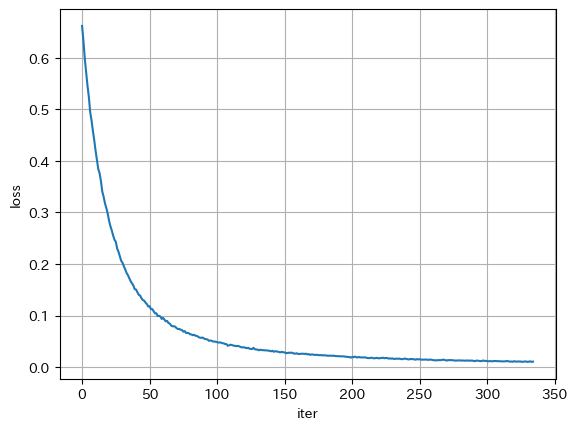

In [32]:
plt.plot(np.load('./learn_process.npy'))
plt.xlabel('iter')
plt.ylabel('loss')
plt.grid()
plt.show()

### テストデータで評価
学習時には，学習データだけでlossやscoreを表示するのではなく，テストデータ（もっとちゃんと言えば，検証データ）を用いて，学習していないデータへの当てはまりを見ながら学習を進めていきたいという気持ちがあります． 
そこで，学習時に，train_lossだけでなく，テストデータ（検証データ）の予測の精度についても出力するような処理を実装することが多いです．以下に，実装の例を載せますが，実効には時間が非常にかかるので，スクリプト作成者は実行していません笑

In [33]:
# # 学習回数
# iter_num = 10000
# train_size = X_train.shape[0]
# batch_size = 100
# learning_rate = 0.1

# train_loss_list = []
# train_acc_list = []
# test_acc_list = []

# iter_per_epoch = max(train_size / batch_size, 1)

# network = TwoLayerNet(input_size=28*28, hidden_size=50, output_size=10)

# for i in range(iter_num):
#     batch_mask = np.random.choice(train_size, batch_size)
#     X_batch = X_train[batch_mask]
#     t_batch = t_train[batch_mask]

#     grad = network.numerical_gradient(X_batch, t_batch)
#     for key in ['W1', 'b1', 'W2', 'b2']:
#         network.params[key] -= learning_rate * grad[key]
#     loss = network.loss(X_batch, t_batch)
#     print(f'Loss of iter {i}: {loss:.5f}')
#     train_loss_list.append(loss)

#     if i % iter_per_epoch == 0:
#         train_acc = network.accuracy(X_train, t_train)
#         test_acc = network.accuracy(X_test, t_test)
#         train_acc_list.append(train_acc)
#         test_acc_list.append(test_acc)
#         print(f'train acc, test acc | {train_acc}, {test_acc}')

上のコードでは，主に以下の点が異なります．
|箇所|していること|
|-|-|
|train_acc_list|学習データの方での精度を格納するためのリスト|
|test_acc_list|テストデータ（検証データ）に対する精度を格納するリスト|
|iter_per_epoch|どれくらいの学習回数で学習データを1周するか|
|後半の６行|iter_per_epochごとに，学習データとテストデータの精度を計算&出力|


# まとめ
パラメータを学習するために，損失関数という指標を導入し，勾配法を用いて，その指標がより良い値となるように，パラメータを更新していく流れを説明しました．また，学習データセットについて，訓練データと，テストデータに分割するほか，学習時においては，ミニバッチ（あるいは単にバッチという）物に，訓練データを分割することについて触れました．  
ここまでの話では，数値微分について学びましたが，各係数に対して，数値微分を求める事は，非常に大変であり，pythonの処理速度ではなおさら時間がかかってしまいます．実際，上にある学習コードを実行してみれば，そこまで複雑ではないモデルであるのに，学習にかなり時間がかかっています．ここからは，数値微分ではなく，解析的微分を導入していくために，必要なことについて，話を進めていきます．